## HCP individualized connectome prediction

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader
from data.data_utils import *

In [2]:
import importlib
import data.hcp_dataset
import data.dataset_utils 
import data.data_utils
importlib.reload(data.hcp_dataset)
importlib.reload(data.dataset_utils)
importlib.reload(data.data_utils)
from data.hcp_dataset import *
from data.dataset_utils import *
from data.data_utils import *
from data.hcp_dataset import HCP_Base, HCP_Partition

In [3]:
participants_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/HCP-YA_dataset/participants.tsv"
participants_df = pd.read_csv(participants_path, sep='\t')

In [4]:
participants_df.head()

participant_id  subject  age sex train_val_test
0     sub-100206   100206   27   M          train
1     sub-100307   100307   27   F          train
2     sub-100408   100408   33   M            val
3     sub-100610   100610   27   M          train
4     sub-101006   101006   35   F            val

In [ ]:
# Option to select either "Glasser" or "S456" parcellation
parcellation = "Glasser"  # options: "Glasser" or "S456"

if parcellation == "S456":
    # Use 4S456Parcels data
    sc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_SCifod2actvolnorm.mat"
    fc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_FCcorrhpf.mat"
elif parcellation == "Glasser":
    # Use Glasser data
    sc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_SCifod2actvolnorm.mat"
    fc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_FCcorrhpf.mat"
else:
    raise ValueError(f'Invalid parcellation: must be "Glasser" or "S456"')

# Load the structural connectivity (SC) .mat file
sc_mat = scipy.io.loadmat(sc_mat_path)

sc_subjects = sc_mat['subjects']
sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]

sc_cell = sc_mat['SC']
sc_cell = np.squeeze(sc_cell)  # Make 1D if needed
n_sc_subj = sc_cell.shape[0]
# Each element is nparcel x nparcel
sc_matrices = np.stack([sc_cell[i] for i in range(n_sc_subj)], axis=0)
sc_triangles = np.stack([square2tri(sc_matrices[i], k=1) for i in range(n_sc_subj)], axis=0)

# Load the functional connectivity (FC) .mat file
fc_mat = scipy.io.loadmat(fc_mat_path)

fc_subjects = fc_mat['subjects']
fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]

fc_cell = fc_mat['FC']
fc_cell = np.squeeze(fc_cell)  # Make 1D if needed
n_fc_subj = fc_cell.shape[0]
# Each element is nparcel x nparcel
fc_matrices = np.stack([fc_cell[i] for i in range(n_fc_subj)], axis=0)
fc_triangles = np.stack([square2tri(fc_matrices[i], k=1) for i in range(n_fc_subj)], axis=0)

/tmp/ipykernel_3739129/1198866335.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]
/tmp/ipykernel_3739129/1198866335.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]


In [6]:
print("fc_subjects shape:", np.shape(fc_subjects))
print("fc_matrices shape:", fc_matrices.shape)
print("fc_triangles shape:", fc_triangles.shape, '\n')

print("sc_subjects shape:", np.shape(sc_subjects))
print("sc_matrices shape:", sc_matrices.shape)
print("sc_triangles shape:", sc_triangles.shape)


fc_subjects shape: (957,)
fc_matrices shape: (957, 360, 360)
fc_triangles shape: (957, 64620) 

sc_subjects shape: (957,)
sc_matrices shape: (957, 360, 360)
sc_triangles shape: (957, 64620)


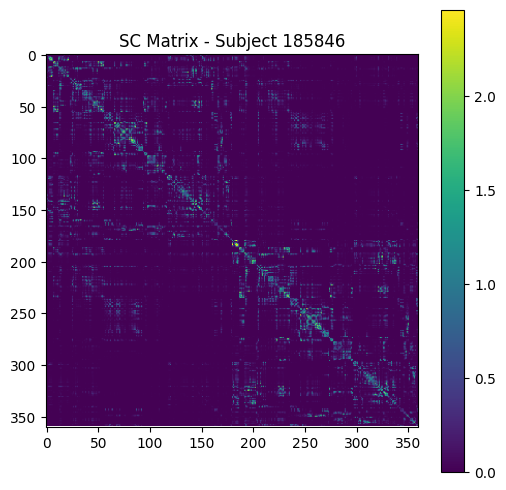

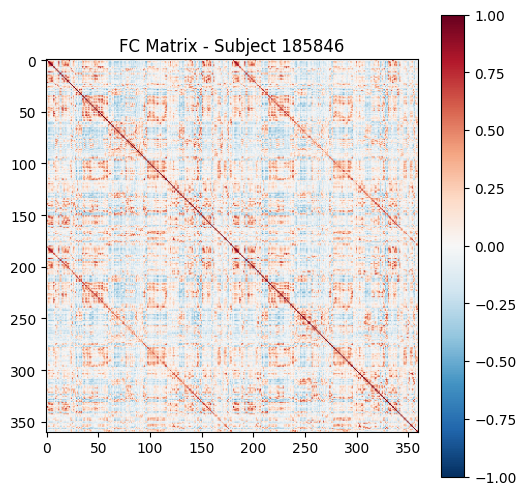

In [7]:
import random
import matplotlib.pyplot as plt

# Pick a random subject index that is present in both SC and FC sets
common_subjects = list(set(sc_subjects) & set(fc_subjects))
if not common_subjects:
    raise ValueError("No subjects in common between SC and FC datasets.")

# Choose a random subject
rand_subject = random.choice(common_subjects)

# Find index of this subject in sc_subjects and fc_subjects
sc_idx = sc_subjects.index(rand_subject)
fc_idx = fc_subjects.index(rand_subject)

# Get the full matrices (not just triangles)
sc_matrix = sc_matrices[sc_idx]
fc_matrix = fc_matrices[fc_idx]

# Plot SC matrix (ensure image is square)
plt.figure(figsize=(6, 6))
plt.imshow(sc_matrix, aspect='equal', cmap='viridis')
plt.title(f"SC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()

# Plot FC matrix (ensure image is square) with colormap RdBu_r and colorbar from -1 to 1
plt.figure(figsize=(6, 6))
plt.imshow(fc_matrix, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title(f"FC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()


Data loader logic walk through

In [5]:
HCP_Dataset = HCP_Base(parcellation="Glasser", shuffle_seed=0)

In [6]:
HCP_Dataset.metadata_df.head()

subject train_val_test  age age_3y_bin sex  \
0   100206          train   27      25-27   M   
1   100307          train   27      25-27   F   
2   100408            val   33      31-33   M   
3   100610          train   27      25-27   M   
4   101006            val   35      34-36   F   

                             Race_Ethnicity Family_Relation          Family_ID  
0                 White_Not Hispanic/Latino         NotTwin        56037_85858  
1                 White_Not Hispanic/Latino              MZ        51488_81352  
2                 White_Not Hispanic/Latino              MZ        51730_81594  
3                 White_Not Hispanic/Latino              DZ        52813_82634  
4  Black or African Am._Not Hispanic/Latino              MZ  51283_52850_81149

In [7]:
HCP_Dataset.freesurfer_df.head()

subject  FS_IntraCranial_Vol  FS_BrainSeg_Vol  FS_BrainSeg_Vol_No_Vent  \
1   100206         1.864518e+06        1406924.0                1389007.0   
2   100307         1.512540e+06        1109710.0                1098854.0   
3   100408         1.684117e+06        1280171.0                1260943.0   
4   100610         1.816044e+06        1321362.0                1306929.0   
5   101006         1.437868e+06        1053766.0                1038408.0   

   FS_BrainSeg_Vol_No_Vent_Surf  FS_LCort_GM_Vol  FS_RCort_GM_Vol  \
1                  1.386836e+06         304488.0         305634.0   
2                  1.097122e+06         240030.0         243207.0   
3                  1.259250e+06         260695.0         265243.0   
4                  1.304569e+06         276506.0         278002.0   
5                  1.037793e+06         203718.0         210539.0   

   FS_TotCort_GM_Vol  FS_SubCort_GM_Vol  FS_Total_GM_Vol  ...  \
1           610122.0            70240.0         807245.0  ...   
2           483238.0            56623.0         664124.0  ...   
3           525938.0            63869.0         726206.0  ...   
4           554508.0            74869.0         762308.0  ...   
5           414257.0            58813.0         579632.0  ...   

   FS_R_Rostralanteriorcingulate_Area  FS_R_Rostralmiddlefrontal_Area  \
1                               791.0                          8627.0   
2                               505.0                          5702.0   
3                               631.0                          7092.0   
4                               629.0                          7027.0   
5                               649.0                          4672.0   

   FS_R_Superiorfrontal_Area  FS_R_Superiorparietal_Area  \
1                     8515.0                      6315.0   
2                     6463.0                      4538.0   
3                     7484.0                      5367.0   
4                     7088.0                      6820.0   
5                     5639.0                      5032.0   

   FS_R_Superiortemporal_Area  FS_R_Supramarginal_Area  FS_R_Frontalpole_Area  \
1                      4337.0                   3522.0                  356.0   
2                      3441.0                   3613.0                  257.0   
3                      3984.0                   4144.0                  298.0   
4                      3876.0                   3730.0                  298.0   
5                      3088.0                   3416.0                  257.0   

   FS_R_Temporalpole_Area  FS_R_Transversetemporal_Area  FS_R_Insula_Area  
1                   500.0                         384.0            2267.0  
2                   412.0                         375.0            2385.0  
3                   410.0                         421.0            2578.0  
4                   393.0                         337.0            2792.0  
5                   471.0                         336.0            2290.0  

[5 rows x 200 columns]

Test dataloaders

In [8]:
HCP_train = HCP_Partition(HCP_Dataset, "train")
HCP_val = HCP_Partition(HCP_Dataset, "val")
HCP_test = HCP_Partition(HCP_Dataset, "test")

HCP_train_loader = DataLoader(HCP_train, batch_size=64, shuffle=True)
HCP_val_loader = DataLoader(HCP_val, batch_size=64, shuffle=True)
HCP_test_loader = DataLoader(HCP_test, batch_size=64, shuffle=True)

Extract data into np arrays for local analysis

In [9]:
sc_train_matrices = HCP_Dataset.sc_upper_triangles[HCP_train.indices]
sc_train_avg = HCP_Dataset.sc_train_avg
sc_val_matrices = HCP_Dataset.sc_upper_triangles[HCP_val.indices]
sc_val_avg = np.mean(sc_val_matrices, axis=0)
sc_test_matrices = HCP_Dataset.sc_upper_triangles[HCP_test.indices]
sc_test_avg = np.mean(sc_test_matrices, axis=0)

fc_train_matrices = HCP_Dataset.fc_upper_triangles[HCP_train.indices]
fc_train_avg = HCP_Dataset.fc_train_avg
fc_val_matrices = HCP_Dataset.fc_upper_triangles[HCP_val.indices]
fc_val_avg = np.mean(fc_val_matrices, axis=0)
fc_test_matrices = HCP_Dataset.fc_upper_triangles[HCP_test.indices]
fc_test_avg = np.mean(fc_test_matrices, axis=0)

SC Train vs Val Pearson r: 0.9983357056068821
SC Train vs Test Pearson r: 0.99912946635816
SC Val vs Test Pearson r: 0.9979011787466778


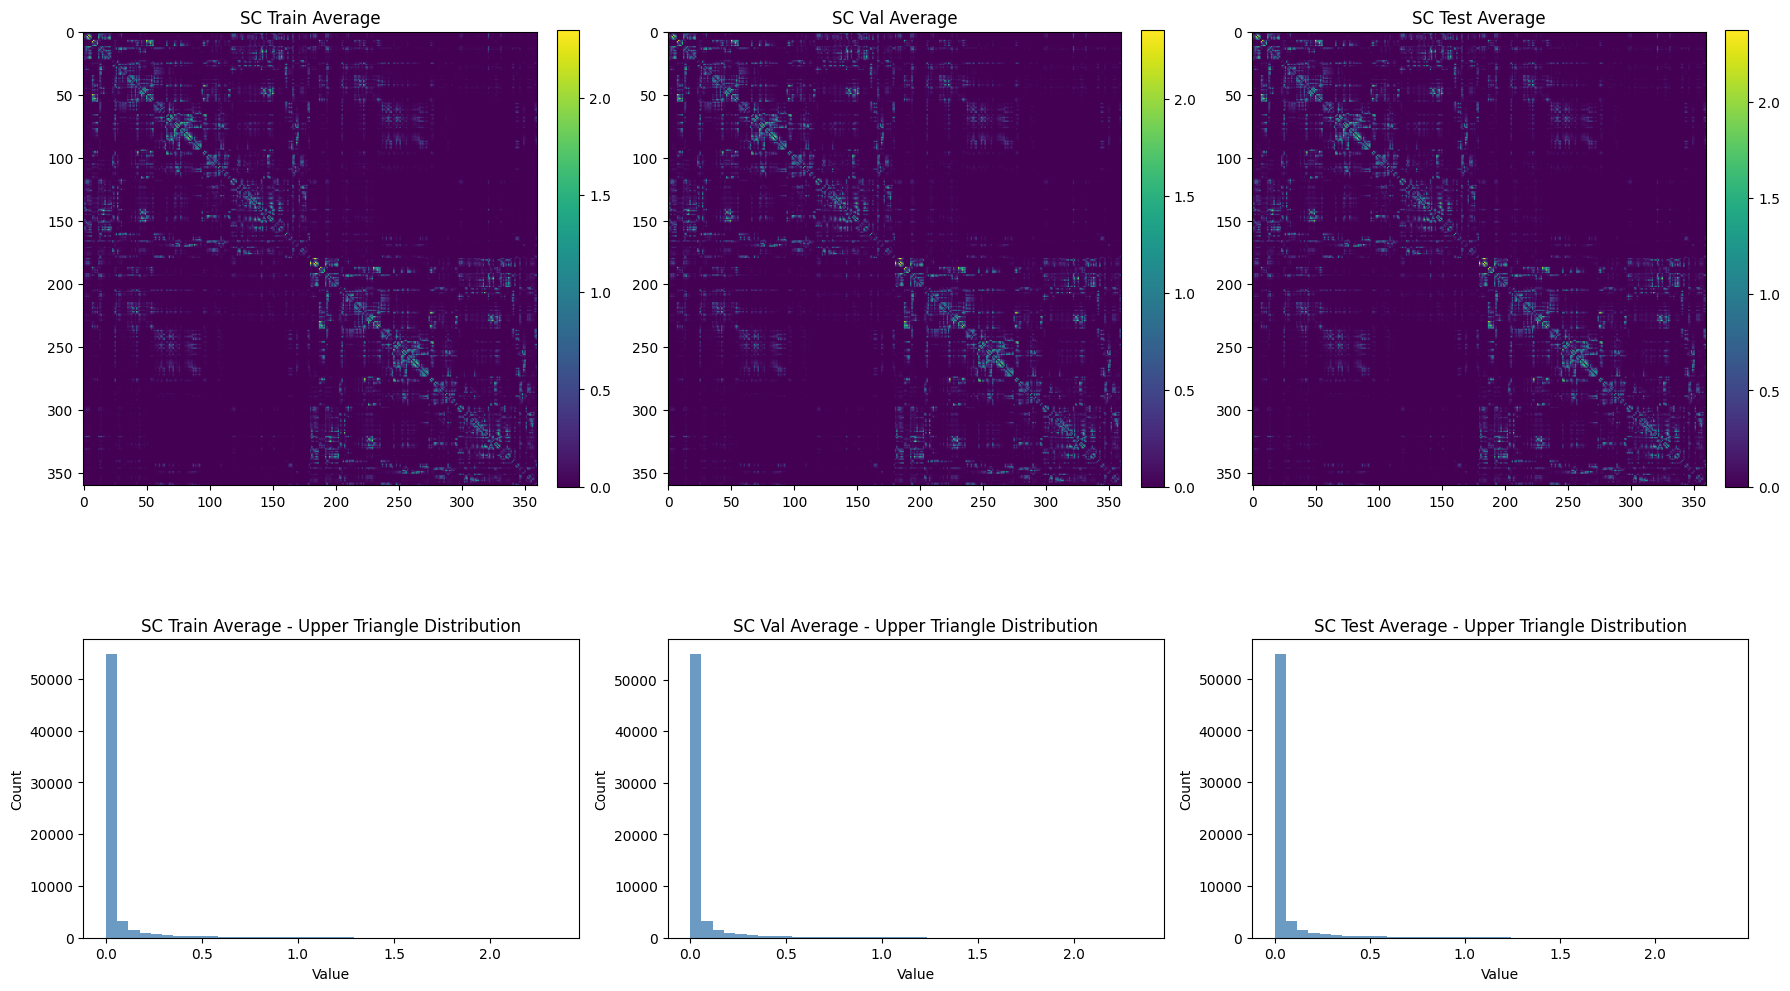

FC Train vs Val Pearson r: 0.99645344362941
FC Train vs Test Pearson r: 0.9980708636132105
FC Val vs Test Pearson r: 0.994744046458122


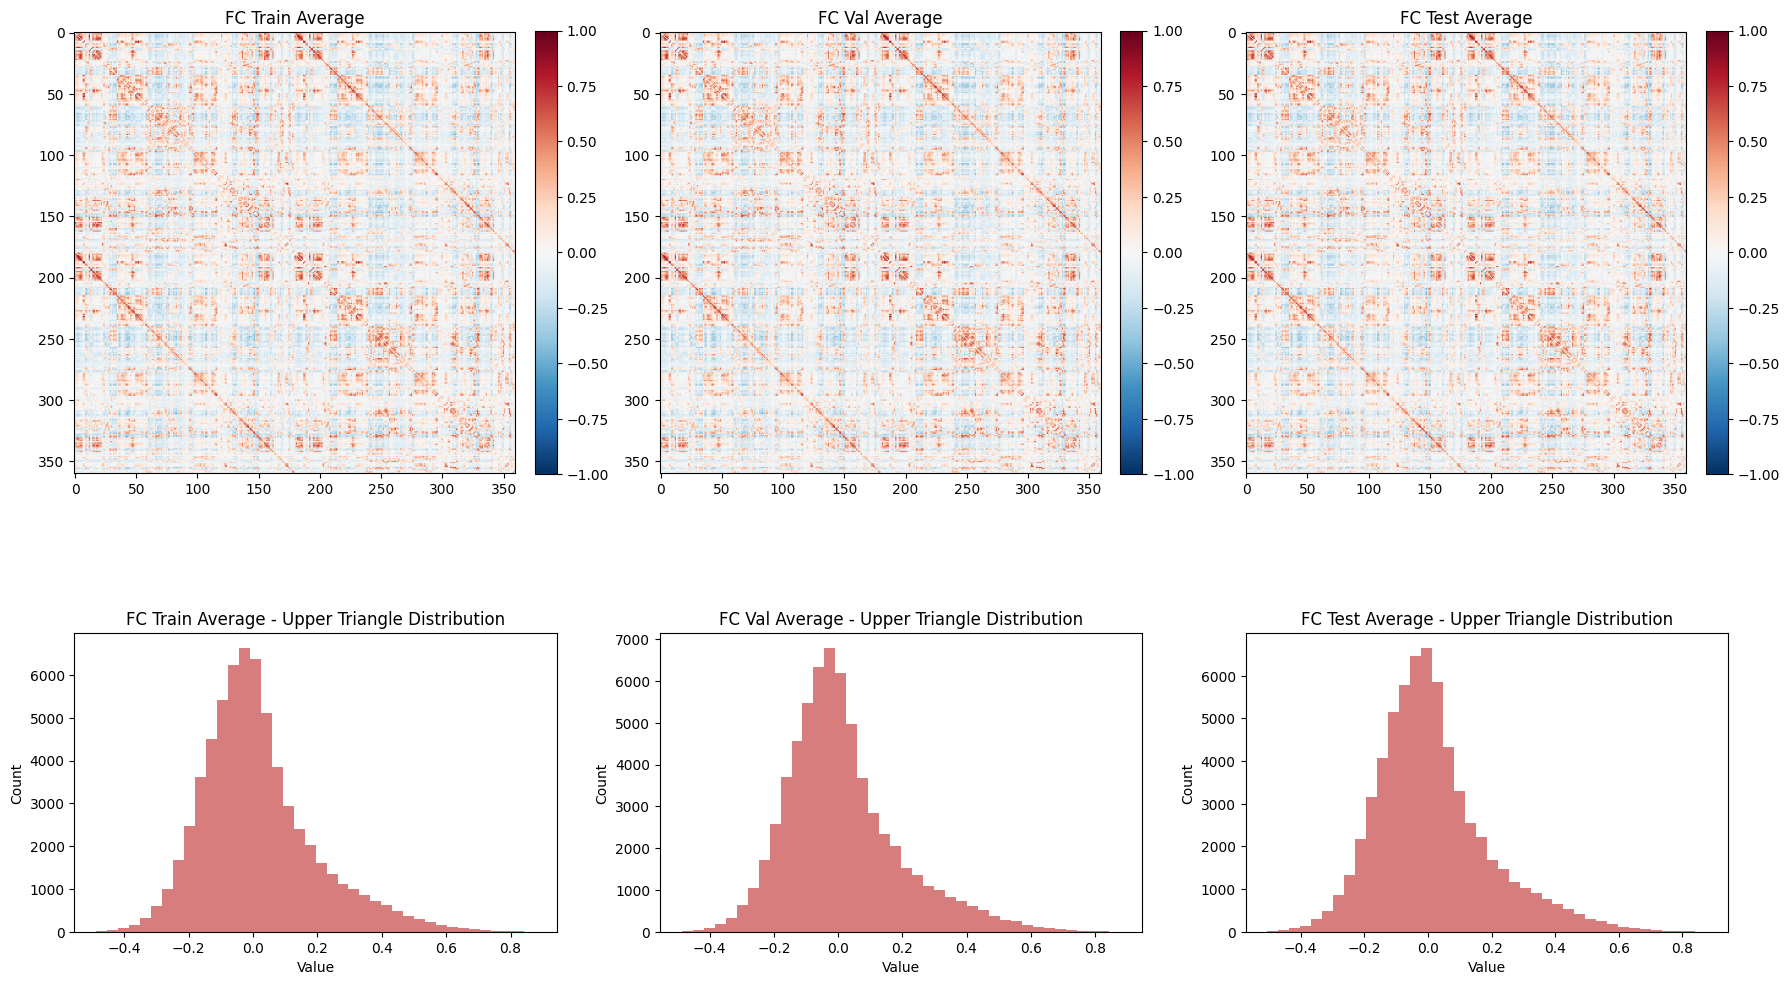

In [16]:
# Plot average SC matrices for train, val, test splits using tri2square
sc_tri_indices = np.triu_indices(360, k=1)
sc_train_avg_mat = tri2square(sc_train_avg, tri_indices=sc_tri_indices)
sc_val_avg_mat = tri2square(sc_val_avg, tri_indices=sc_tri_indices)
sc_test_avg_mat = tri2square(sc_test_avg, tri_indices=sc_tri_indices)

print("SC Train vs Val Pearson r:", tri_corr(sc_train_avg_mat, sc_val_avg_mat))
print("SC Train vs Test Pearson r:", tri_corr(sc_train_avg_mat, sc_test_avg_mat))
print("SC Val vs Test Pearson r:", tri_corr(sc_val_avg_mat, sc_test_avg_mat))

# PLOT: imshow and histogram for each SC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
sc_avg_mats = [sc_train_avg_mat, sc_val_avg_mat, sc_test_avg_mat]
sc_titles = ["SC Train Average", "SC Val Average", "SC Test Average"]

for i, (mat, title) in enumerate(zip(sc_avg_mats, sc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='viridis')
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='steelblue', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()

# Plot average FC matrices for train, val, test splits using tri2square
fc_tri_indices = np.triu_indices(360, k=1)
fc_train_avg_mat = tri2square(fc_train_avg, tri_indices=fc_tri_indices)
fc_val_avg_mat = tri2square(fc_val_avg, tri_indices=fc_tri_indices)
fc_test_avg_mat = tri2square(fc_test_avg, tri_indices=fc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average FCs
print("FC Train vs Val Pearson r:", tri_corr(fc_train_avg_mat, fc_val_avg_mat))
print("FC Train vs Test Pearson r:", tri_corr(fc_train_avg_mat, fc_test_avg_mat))
print("FC Val vs Test Pearson r:", tri_corr(fc_val_avg_mat, fc_test_avg_mat))

# PLOT: imshow and histogram for each FC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
fc_avg_mats = [fc_train_avg_mat, fc_val_avg_mat, fc_test_avg_mat]
fc_titles = ["FC Train Average", "FC Val Average", "FC Test Average"]

for i, (mat, title) in enumerate(zip(fc_avg_mats, fc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='indianred', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()


### PCA info loss eval

In [24]:
# how much info loss is attributable to PCA?
import models
import importlib
importlib.reload(models)
from models import *

Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


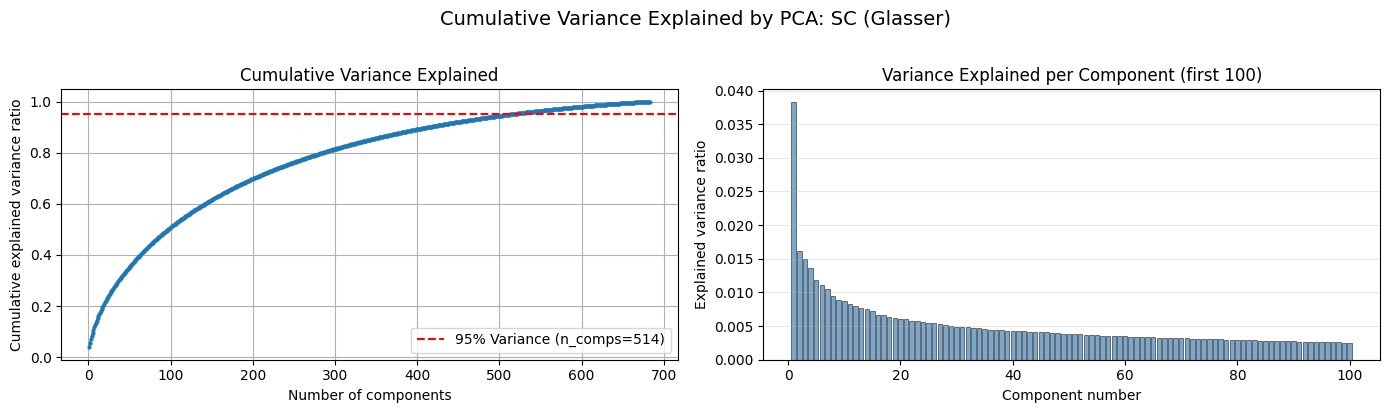

128 components: Train R^2: 0.40679  Val R^2: 0.06451  Test R^2: 0.10323
256 components: Train R^2: 0.59351  Val R^2: 0.01677  Test R^2: 0.07877
512 components: Train R^2: 0.86376  Val R^2: -0.11515  Test R^2: -0.01398


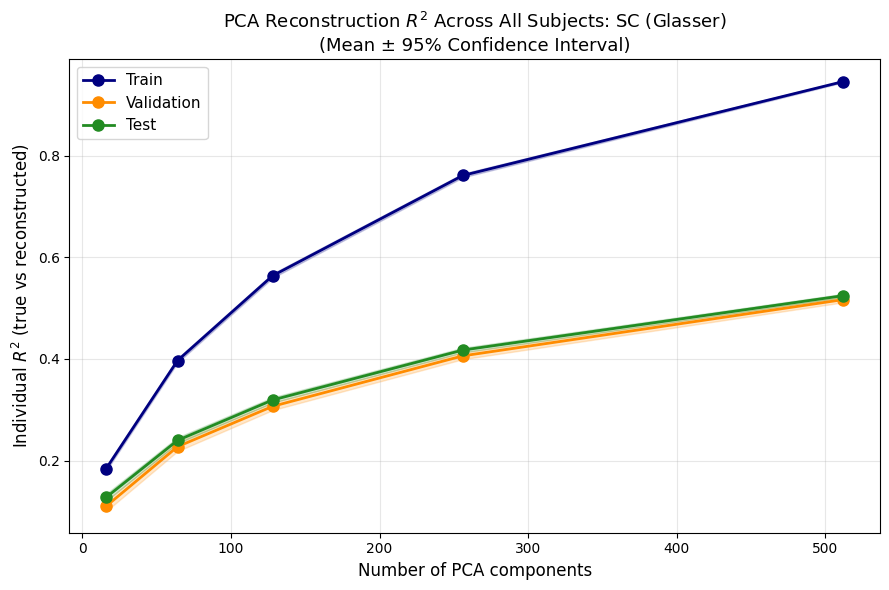

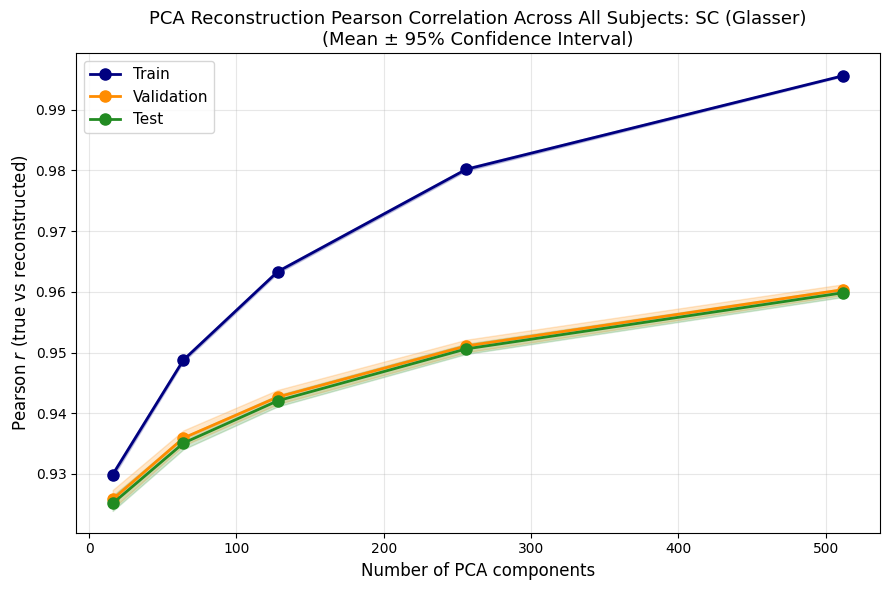

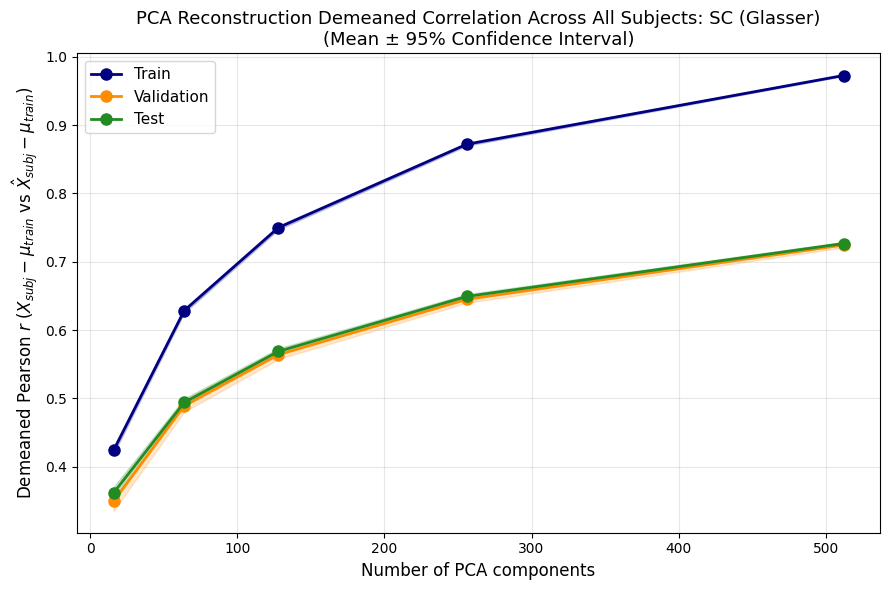

In [22]:
# how much info loss is attributable to PCA? (for SC)

import models
import importlib
importlib.reload(models)
from models import *

pca, scores_dict, loadings = run_pca_and_plot(
    sc_train_matrices, sc_val_matrices, sc_test_matrices,
    train_ids=HCP_Dataset.trainvaltest_partition_indices["train"], 
    val_ids=HCP_Dataset.trainvaltest_partition_indices["val"], 
    test_ids=HCP_Dataset.trainvaltest_partition_indices["test"],
    modality="SC", parcellation="Glasser")

Loadings shape (n_components, n_features): (683, 683)
Train scores shape (n_train_samples, n_components): (64620, 683)


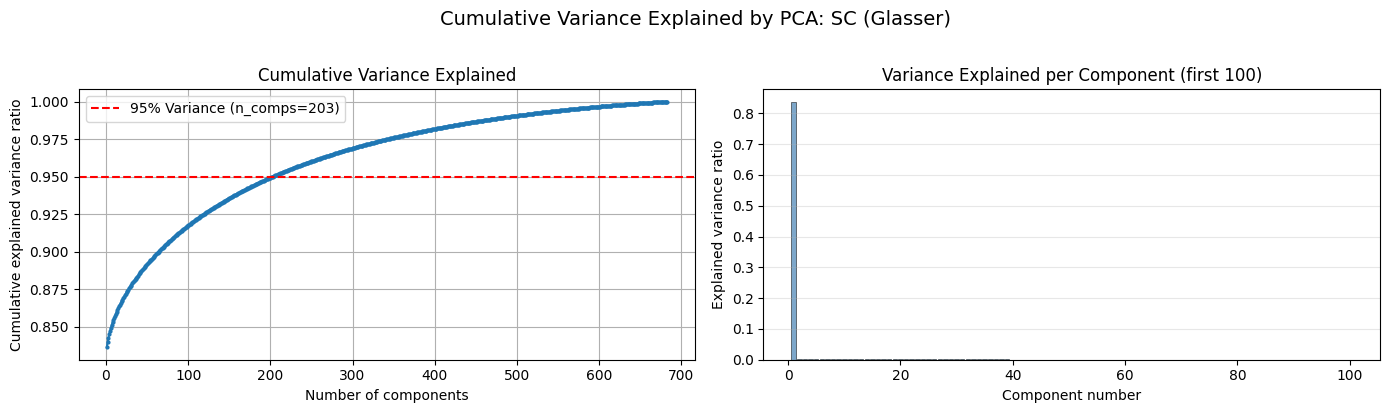

In [25]:
run_pca_and_plot(
    sc_train_matrices.T, sc_val_matrices.T, sc_test_matrices.T,
    train_ids=HCP_Dataset.trainvaltest_partition_indices["train"], 
    val_ids=HCP_Dataset.trainvaltest_partition_indices["val"], 
    test_ids=HCP_Dataset.trainvaltest_partition_indices["test"],
    modality="SC", parcellation="Glasser", reconstruct_and_plot=False)


Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


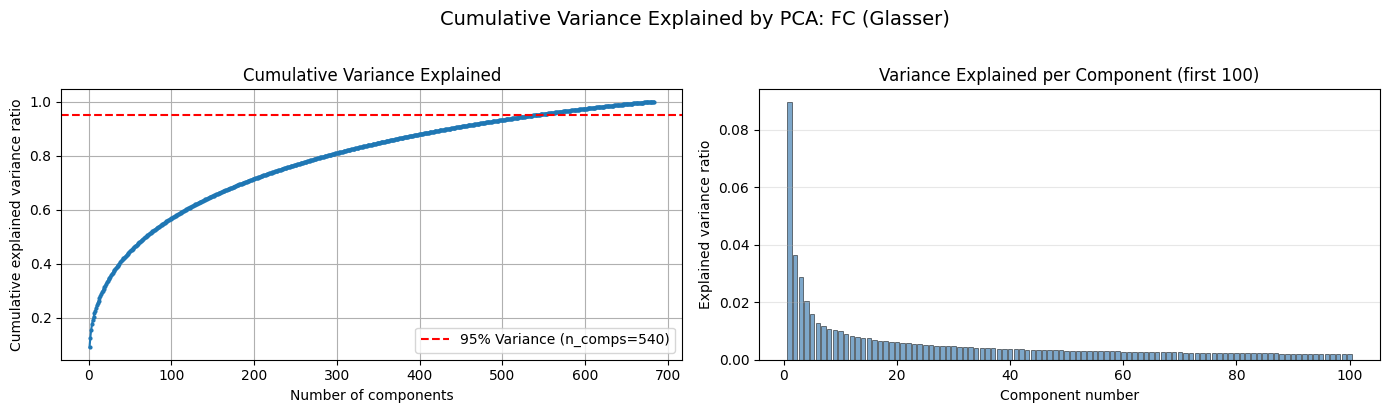

128 components: Train R^2: 0.58634  Val R^2: 0.36337  Test R^2: 0.36033
256 components: Train R^2: 0.74633  Val R^2: 0.41184  Test R^2: 0.40817
512 components: Train R^2: 0.92892  Val R^2: 0.45751  Test R^2: 0.45412


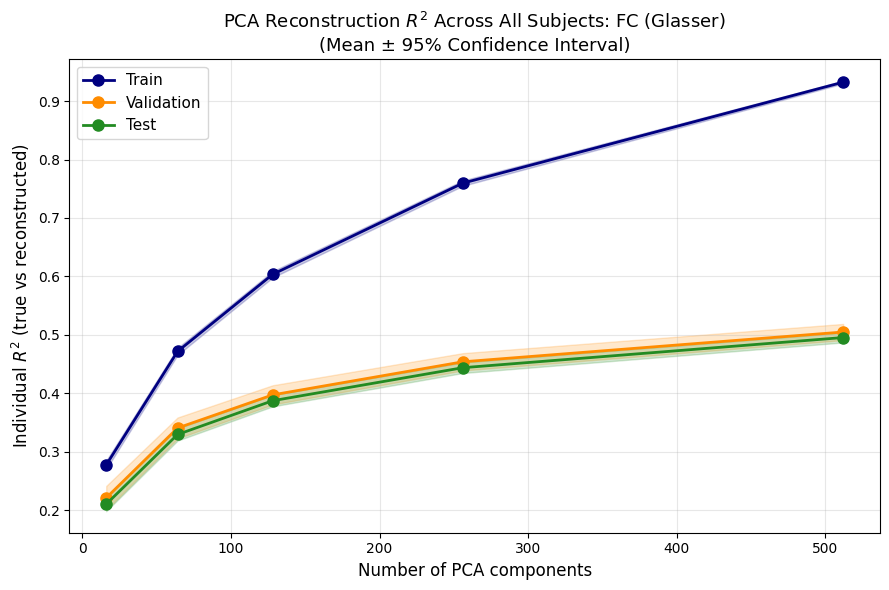

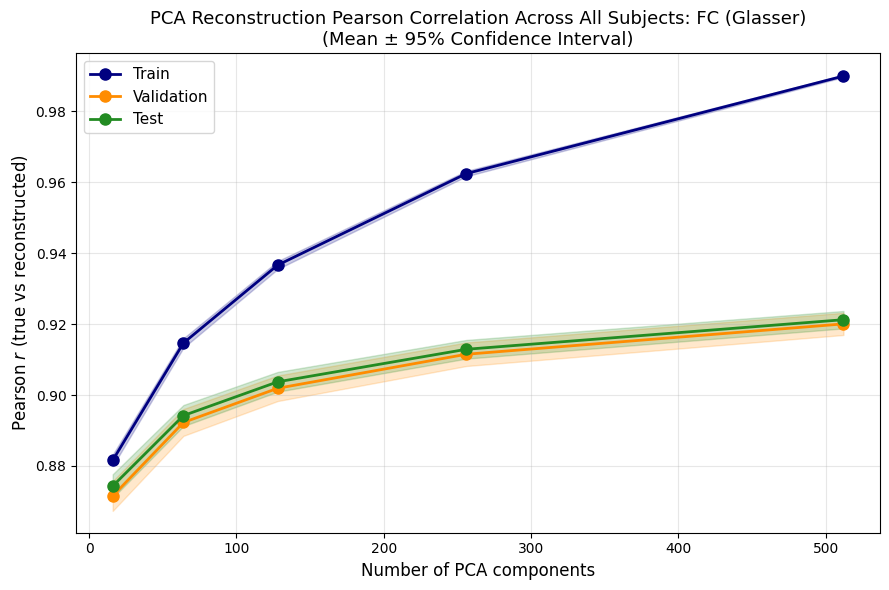

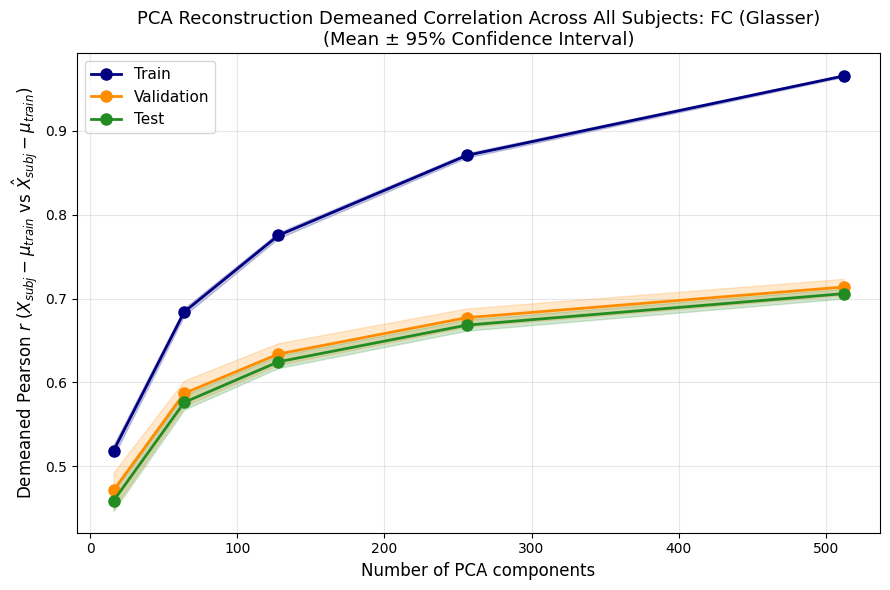

In [ ]:
pca, scores_dict, loadings = run_pca_and_plot(
    fc_train_matrices, fc_val_matrices, fc_test_matrices,
    train_ids=HCP_Dataset.trainvaltest_partition_indices["train"], 
    val_ids=HCP_Dataset.trainvaltest_partition_indices["val"], 
    test_ids=HCP_Dataset.trainvaltest_partition_indices["test"],
    modality="FC", parcellation="Glasser")

Loadings shape (n_components, n_features): (683, 683)
Train scores shape (n_train_samples, n_components): (64620, 683)


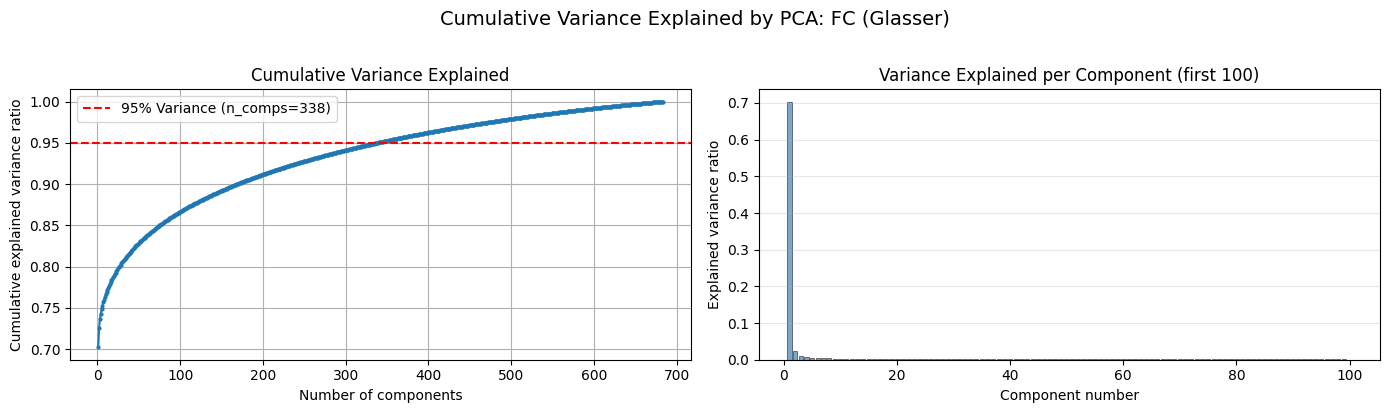

In [26]:
run_pca_and_plot(
    fc_train_matrices.T, fc_val_matrices.T, fc_test_matrices.T,
    train_ids=HCP_Dataset.trainvaltest_partition_indices["train"], 
    val_ids=HCP_Dataset.trainvaltest_partition_indices["val"], 
    test_ids=HCP_Dataset.trainvaltest_partition_indices["test"],
    modality="FC", parcellation="Glasser", reconstruct_and_plot=False)


Assess subject-wise PCA variance

In [27]:
from scipy.spatial.distance import pdist

In [ ]:
# Extract component 1
v1 = pca.components_[0]        # shape: (n_subjects,)
# Extract score 1
s1 = scores_dict['train'][:, 0] # shape: (n_subjects,)
# Recreate rank 1 approximation of X
X_rank1 = s1[:, None] * v1[None, :]

# Compute the total edge variance across subjects for true data and rank 1 approx
var_X = np.var(fc_train_matrices, axis=1).sum()
var_X_rank1 = np.var(X_rank1, axis=1).sum()

# Compute the proportion of variance explained by the rank 1 approximation
print(f"Proportion of variance explained by rank 1 approximation: {var_X_rank1 / var_X}")


# subject vectors across edges
orig_subject_dists = pdist(fc_train_matrices.T, metric='euclidean')
pc1_subject_dists  = pdist(X_rank1.T, metric='euclidean')

print("Mean subject distance (original):", orig_subject_dists.mean())
print("Mean subject distance (PC1 only):", pc1_subject_dists.mean())
# Check if subject-wise connetcomes in original and rank 1 space have similar distances between them


'''
Key logic
	•	If PC1 preserves variance but
	•	collapses subject distances substantially

→ then subjects are not well distinguished by the dominant mode
→ differences are nuanced and live in higher PCs
'''

Proportion of variance explained by rank 1 approximation: 0.03826615320686676


Assess cross-model PCA model

In [75]:
import models
from models import *
from models import CrossModalPCA
importlib.reload(models)
from models import *

import importlib
import eval
importlib.reload(eval)
from eval import *


In [50]:
HCP_Dataset = HCP_Base(parcellation="Glasser", shuffle_seed=0, source="SC", target="FC")

# redefine dataset and loaders
HCP_train = HCP_Partition(HCP_Dataset, "train")
HCP_val = HCP_Partition(HCP_Dataset, "val")
HCP_test = HCP_Partition(HCP_Dataset, "test")

HCP_train_loader = DataLoader(HCP_train, batch_size=256, shuffle=True)
HCP_val_loader = DataLoader(HCP_val, batch_size=256, shuffle=True)
HCP_test_loader = DataLoader(HCP_test, batch_size=256, shuffle=True)

cross_modal_pca_model = CrossModalPCA(HCP_Dataset, num_components=256)

# grab predictions
device = cross_modal_pca_model.device if hasattr(cross_modal_pca_model, 'device') else torch.device("cpu")
train_preds, train_targets = predict_from_loader(cross_modal_pca_model, HCP_train_loader, device=device)
val_preds, val_targets = predict_from_loader(cross_modal_pca_model, HCP_val_loader, device=device)
test_preds, test_targets = predict_from_loader(cross_modal_pca_model, HCP_test_loader, device=device)

print(train_preds.shape)
print(train_targets.shape)
print(val_preds.shape)
print(val_targets.shape)
print(test_preds.shape)
print(test_targets.shape)

Source mean shape: torch.Size([64620])
Source loadings shape: torch.Size([64620, 683])
Target mean shape: torch.Size([64620])
Target loadings shape: torch.Size([64620, 683])
torch.Size([683, 64620])
torch.Size([683, 64620])
torch.Size([79, 64620])
torch.Size([79, 64620])
torch.Size([195, 64620])
torch.Size([195, 64620])


In [59]:
train_metrics = evaluate_predictions(train_preds, train_targets, HCP_Dataset.fc_train_avg)
val_metrics = evaluate_predictions(val_preds, val_targets, HCP_Dataset.fc_train_avg)
test_metrics = evaluate_predictions(test_preds, test_targets, HCP_Dataset.fc_train_avg)
print("Train metrics:", train_metrics)
print("Val metrics:", val_metrics)
print("Test metrics:", test_metrics)

Train metrics: {'pearson': np.float32(0.77971727), 'demeaned_pearson': np.float64(0.8334579422263022), 'mse': np.float32(0.015982311), 'r2': np.float32(-1.4977989), 'avg_rank': np.float64(0.49595596037634326), 'top1_acc': np.float64(0.0014641288433382138)}
Val metrics: {'pearson': np.float32(0.8225627), 'demeaned_pearson': np.float64(0.8687486397641792), 'mse': np.float32(0.011896286), 'r2': np.float32(-1.4184192), 'avg_rank': np.float64(0.5156224963948085), 'top1_acc': np.float64(0.0379746835443038)}
Test metrics: {'pearson': np.float32(0.83455074), 'demeaned_pearson': np.float64(0.8746928719168858), 'mse': np.float32(0.011505219), 'r2': np.float32(-0.971421), 'avg_rank': np.float64(0.5313346482577253), 'top1_acc': np.float64(0.0)}


In [ ]:
train_pca_preds, train_pca_targets = evaluate_pca_structure(train_preds, train_targets, HCP_Dataset.fc_train_avg)
val_pca_preds, val_pca_targets = evaluate_pca_structure(val_preds, val_targets, HCP_Dataset.fc_train_avg)
test_pca_preds, test_pca_targets = evaluate_pca_structure(test_preds, test_targets, HCP_Dataset.fc_train_avg)

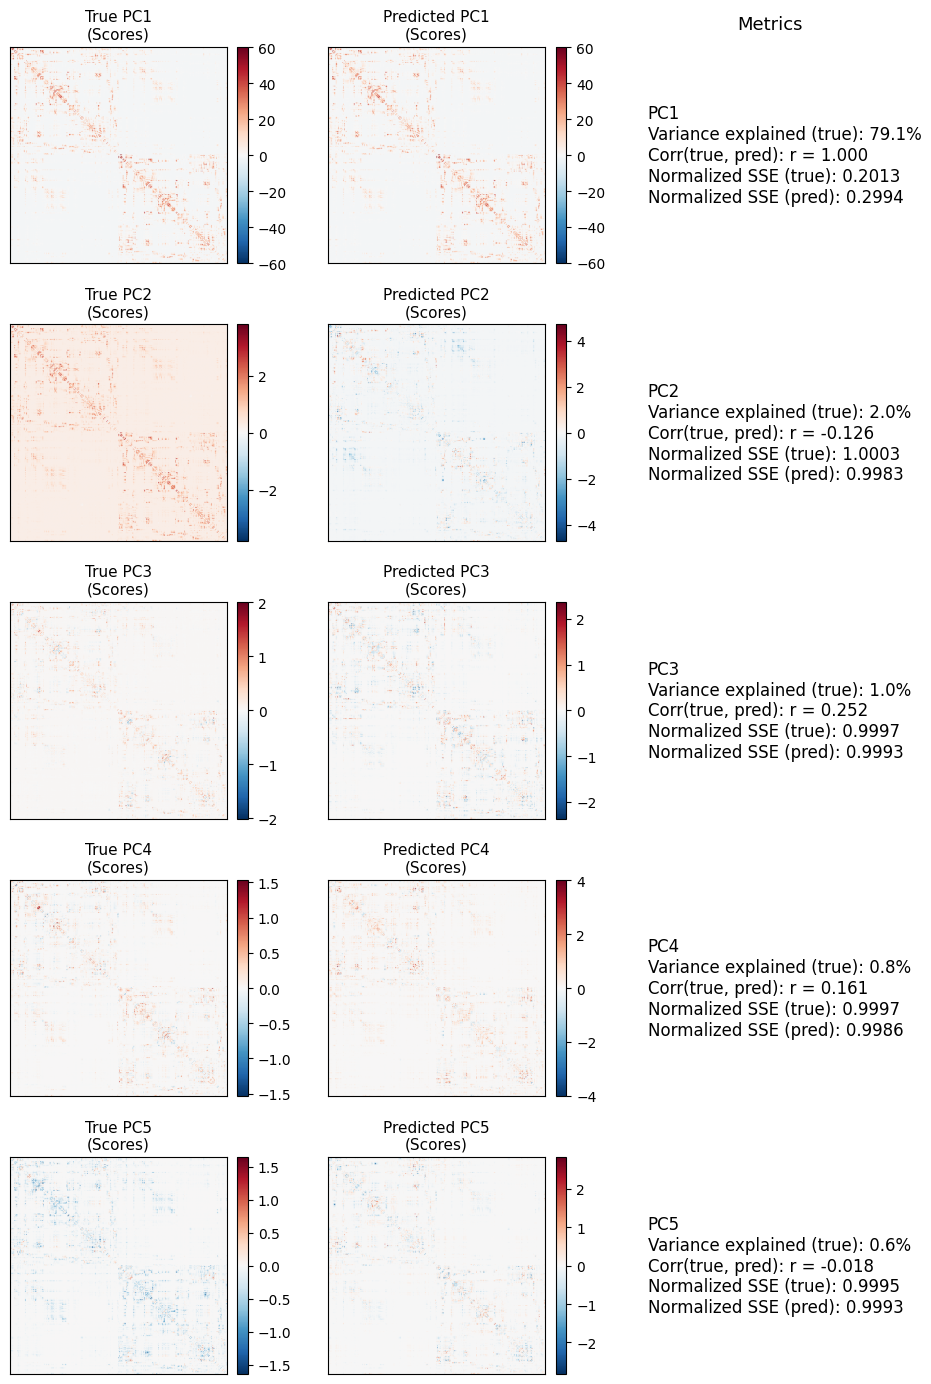

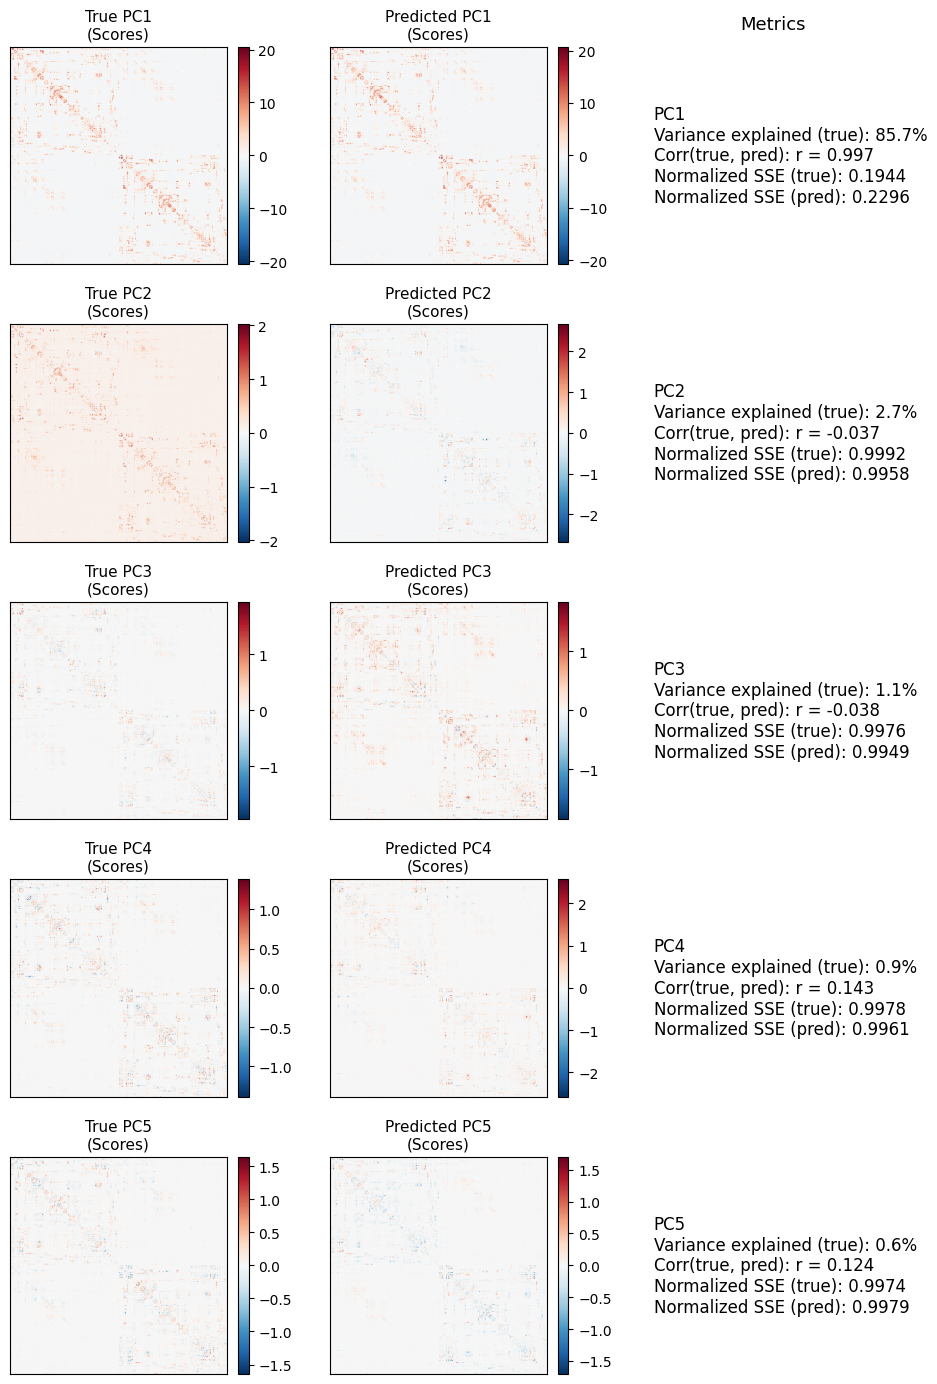

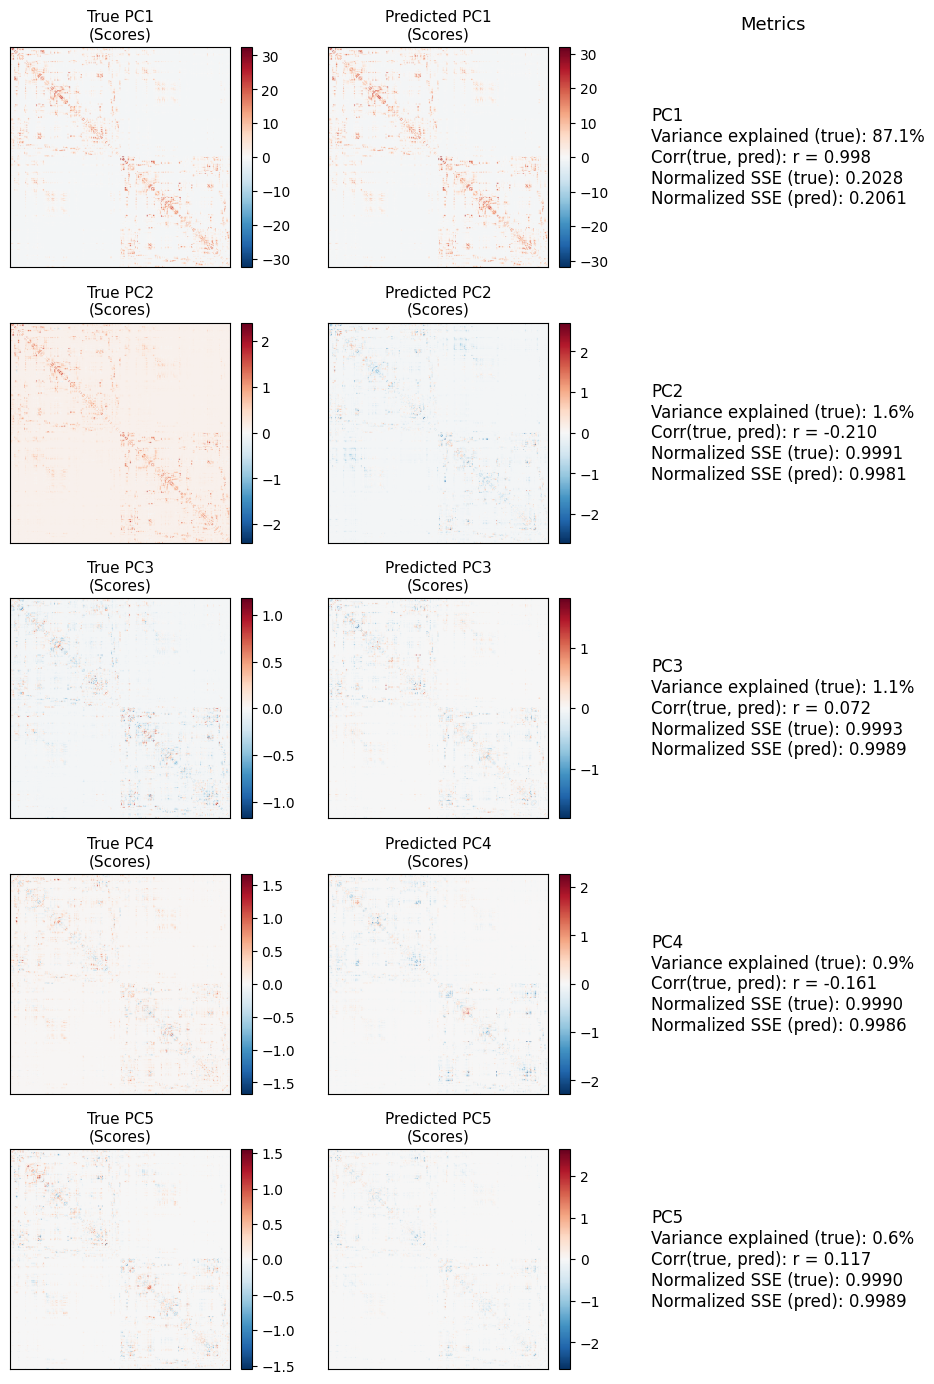

In [76]:
plot_pc_modes_comparison(train_pca_targets, train_pca_preds, train_preds, train_targets, numroi=360, num_pcs=5, diagval=0)
plot_pc_modes_comparison(val_pca_targets, val_pca_preds, val_preds, val_targets, numroi=360, num_pcs=5, diagval=0)
plot_pc_modes_comparison(test_pca_targets, test_pca_preds, test_preds, test_targets, numroi=360, num_pcs=5, diagval=0)

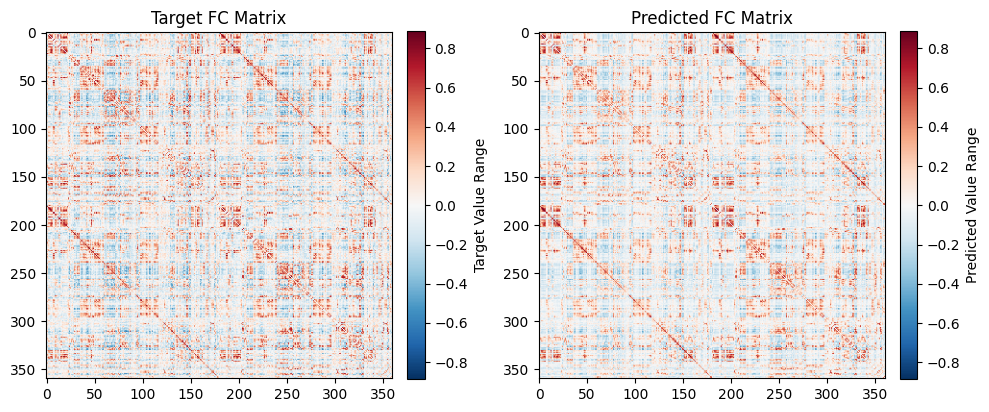

In [52]:
# Reconstruct upper triangle vectors into square matrices using tri2square
n_roi = int((1 + (1 + 8 * train_preds[0].numel())**0.5) / 2)
mat_pred = tri2square(train_preds[0].cpu().numpy(), numroi=n_roi)
mat_true = tri2square(train_targets[0].cpu().numpy(), numroi=n_roi)
# Show target then prediction, just one colorbar

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Dynamic colorbar scaling per matrix
vmax_true = abs(mat_true).max()
vmax_pred = abs(mat_pred).max()

im0 = axes[0].imshow(mat_true, aspect='equal', cmap='RdBu_r', vmin=-vmax_true, vmax=vmax_true)
axes[0].set_title("Target FC Matrix")
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar0.set_label('Target Value Range')

im1 = axes[1].imshow(mat_pred, aspect='equal', cmap='RdBu_r', vmin=-vmax_pred, vmax=vmax_pred)
axes[1].set_title("Predicted FC Matrix")
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Predicted Value Range')

plt.tight_layout()
plt.show()


In [53]:
HCP_Dataset = HCP_Base(parcellation="Glasser", shuffle_seed=0, source="FC", target="SC")

# redefine dataset and loaders
HCP_train = HCP_Partition(HCP_Dataset, "train")
HCP_val = HCP_Partition(HCP_Dataset, "val")
HCP_test = HCP_Partition(HCP_Dataset, "test")

HCP_train_loader = DataLoader(HCP_train, batch_size=256, shuffle=True)
HCP_val_loader = DataLoader(HCP_val, batch_size=256, shuffle=True)
HCP_test_loader = DataLoader(HCP_test, batch_size=256, shuffle=True)

cross_modal_pca_model = CrossModalPCA(HCP_Dataset, num_components=256)

# grab predictions
device = cross_modal_pca_model.device if hasattr(cross_modal_pca_model, 'device') else torch.device("cpu")
train_preds, train_targets = predict_from_loader(cross_modal_pca_model, HCP_train_loader, device=device)
val_preds, val_targets = predict_from_loader(cross_modal_pca_model, HCP_val_loader, device=device)
test_preds, test_targets = predict_from_loader(cross_modal_pca_model, HCP_test_loader, device=device)

print(train_preds.shape)
print(train_targets.shape)
print(val_preds.shape)
print(val_targets.shape)
print(test_preds.shape)
print(test_targets.shape)

Source mean shape: torch.Size([64620])
Source loadings shape: torch.Size([64620, 683])
Target mean shape: torch.Size([64620])
Target loadings shape: torch.Size([64620, 683])
torch.Size([683, 64620])
torch.Size([683, 64620])
torch.Size([79, 64620])
torch.Size([79, 64620])
torch.Size([195, 64620])
torch.Size([195, 64620])


In [54]:
train_metrics = evaluate_predictions(train_preds, train_targets, HCP_Dataset.sc_train_avg)
val_metrics = evaluate_predictions(val_preds, val_targets, HCP_Dataset.sc_train_avg)
test_metrics = evaluate_predictions(test_preds, test_targets, HCP_Dataset.sc_train_avg)

print("Train metrics:", train_metrics)
print("Val metrics:", val_metrics)
print("Test metrics:", test_metrics)

Train metrics: {'pearson': np.float32(0.77971727), 'demeaned_pearson': np.float64(0.001293589995330555), 'mse': np.float32(0.015982311), 'r2': np.float32(-1.4977989), 'avg_rank': np.float64(0.49595596037634326), 'top1_acc': np.float64(0.0014641288433382138)}
Val metrics: {'pearson': np.float32(0.8225627), 'demeaned_pearson': np.float64(0.012330604004493623), 'mse': np.float32(0.011896286), 'r2': np.float32(-1.4184192), 'avg_rank': np.float64(0.5156224963948085), 'top1_acc': np.float64(0.0379746835443038)}
Test metrics: {'pearson': np.float32(0.83455074), 'demeaned_pearson': np.float64(0.009206709620918473), 'mse': np.float32(0.011505219), 'r2': np.float32(-0.971421), 'avg_rank': np.float64(0.5313346482577253), 'top1_acc': np.float64(0.0)}


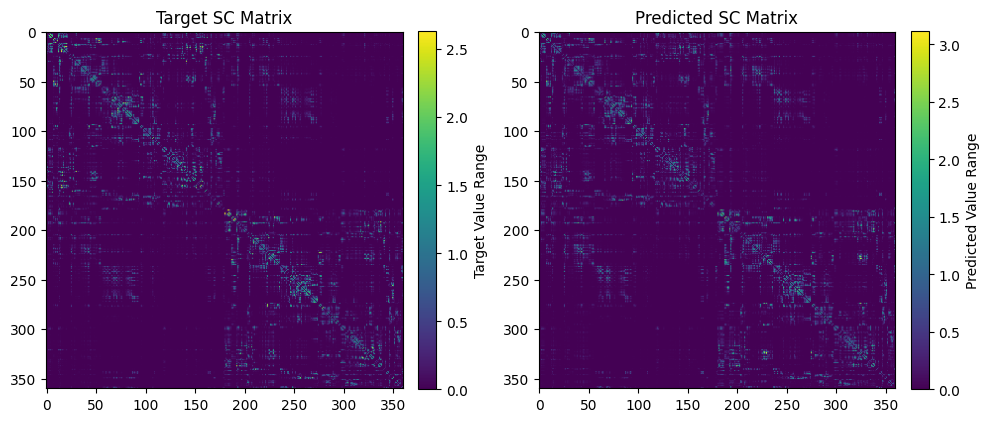

In [55]:
# Reconstruct upper triangle vectors into square matrices using tri2square
n_roi = int((1 + (1 + 8 * train_preds[0].numel())**0.5) / 2)
mat_pred = tri2square(test_preds[0].cpu().numpy(), numroi=n_roi)
mat_true = tri2square(test_targets[0].cpu().numpy(), numroi=n_roi)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Dynamic colorbar scaling per matrix
vmax_true = abs(mat_true).max()
vmax_pred = abs(mat_pred).max()

im0 = axes[0].imshow(mat_true, aspect='equal', cmap='viridis', vmin=0, vmax=vmax_true)
axes[0].set_title("Target SC Matrix")
cbar0 = fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar0.set_label('Target Value Range')

im1 = axes[1].imshow(mat_pred, aspect='equal', cmap='viridis', vmin=0, vmax=vmax_pred)
axes[1].set_title("Predicted SC Matrix")
cbar1 = fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Predicted Value Range')

plt.tight_layout()
plt.show()
